In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
from scipy.stats import norm

from functions import *

In [2]:
data = pd.read_pickle('near_far_df.pkl')
data['index'] = np.arange(0,len(data), 1)

## Data Analysis

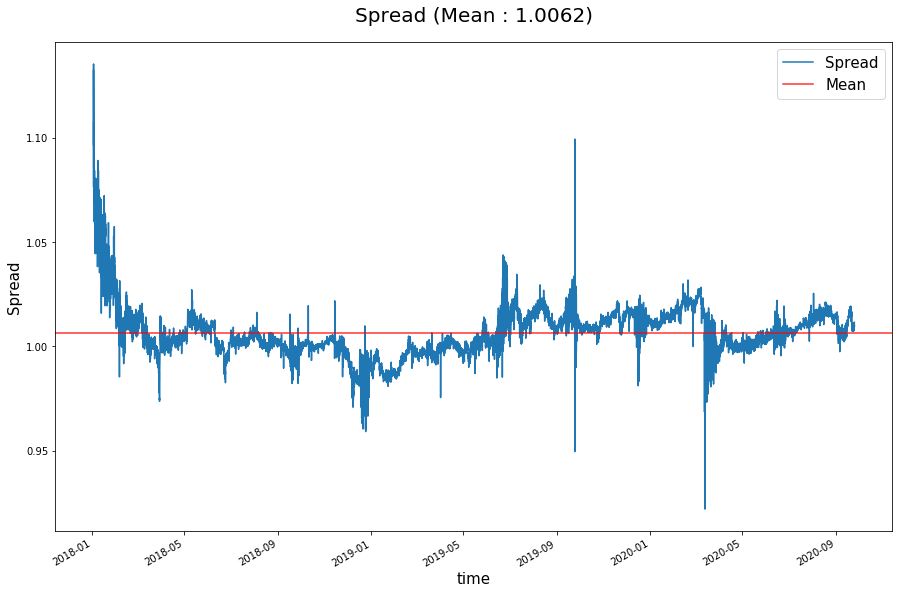

In [3]:
plt.figure(figsize=(15,10))
plt.title('Spread (Mean : {0:.4f})'.format(data['spread'].mean()), fontsize=20, pad=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Spread', fontsize=15)
#plt.xticks(fontsize=10)
#plt.yticks(fontsize=20)
data['spread'].plot(label='Spread')
plt.axhline(data['spread'].mean(), c='r', alpha=0.8, label='Mean')
plt.legend(fontsize=15)
plt.show()

# Stationarity Test
# 데이터의 형태가 평균 근처에서 주기성을 보인다. 실제로 평균회귀 현상이 존재하는 지 검증 -> ADF Test 사용

# ADF Test : 데이터의 Stationarity를 평가하는 방법. y의 증분을 y(t-1)값으로 회귀한 회귀 계수가 1인지를 검정.
### - p-value가 매우 낮아서 유의수준 0.00001에서도 기각된다. 즉, 데이터는 Stationarity가 강하고, Mean Reversion을 이용한 전략을 사용할 수 있다는 근거가 된다.


In [4]:
adfuller_test = adfuller(data['spread'], autolag= "t-stat")
print("ADF test statistic: {0:.4f}".format(adfuller_test[0]))
print("p-value: {0:.7f}".format(adfuller_test[1]))

ADF test statistic: -5.8804
p-value: 0.0000003


# #Mean Reversion
## 1. Mean Reversion Strategy :  평균으로의 회귀 현상을 이용한 전략을 말한다. 장기 가격 수준에서 위쪽이나 아래쪽으로 이탈했을 때 다시 평균으로 회귀할 것을 예상한 포지션을 취하는 전략이다.

# #Implementation
## 1. Bollinger Band : Spread(Far Price / Near Price)의 n기간 이동평균선에 k(상수) * n기간 표준편차를 더하여 Upper Limit, k(상수) *n기간 표준편차를 차감하여 Lower Limit을 설정. 
$$ Upper Limit = SpreadMA(n) + k * SpreadSTD(n) $$
$$ Lower Limit = SpreadMA(n) - k * SpreadSTD(n) $$

## 2. Entry
## - Upper Limit을 위로 돌파 :  Long near, Short Far Position(Spread 축소 예상)
## - Lower Limit을 아래로 돌파 : Short Near, Long Far Position(Spread 확대 예상)
## 3. Out
## - 포지션에서 진입한 상태에서 n일 이동평균선 수준으로 Spread가 돌아올 때 청산.

# #Parameter
## 1. n, k : n은 이동평균선 산출기간, k는 Upper, Lower Limit을 정할 때 표준편차에 곱해주는 계수.
## 2. Rollover : 근월물 만기가 오기 몇 시간 전에 Rollover를 할 것인가 결정.


# #Metric
## 1. Ret : 최종 수익률
## 2. Std : 표준편차
## 3. Sharpe Ratio : Ret/Std

# 아래의 Optimization 과정을 보기 전에 최종적으로 선택된 Optimized Strategy의 Backtest 결과를 먼저 보기

# Bollinger Band Strategy : Optimized Strategy

### Inital Available Balance를 1BTC로 두고, Near Contract와 Far Contract의 포지션 크기는 동일하게 한다. (Leverage가 1인 경우 0.5BTC씩 진입)

In [5]:
## Example
## Timing 전략
n = 1300
k = 1.28
rollover_period = 48
port = bollinger_str(n,k,data)

## Rollover 전략
port['rollover_out'] = rollover_out(data, period=rollover_period)

## Leverage 전략
port['leverage'] = 10 * np.ones(len(port))
  
## Backtest
ret, std, sharpe_ratio, result = backtest(data, port, commission=0.00075)
trades = trade_result(result)

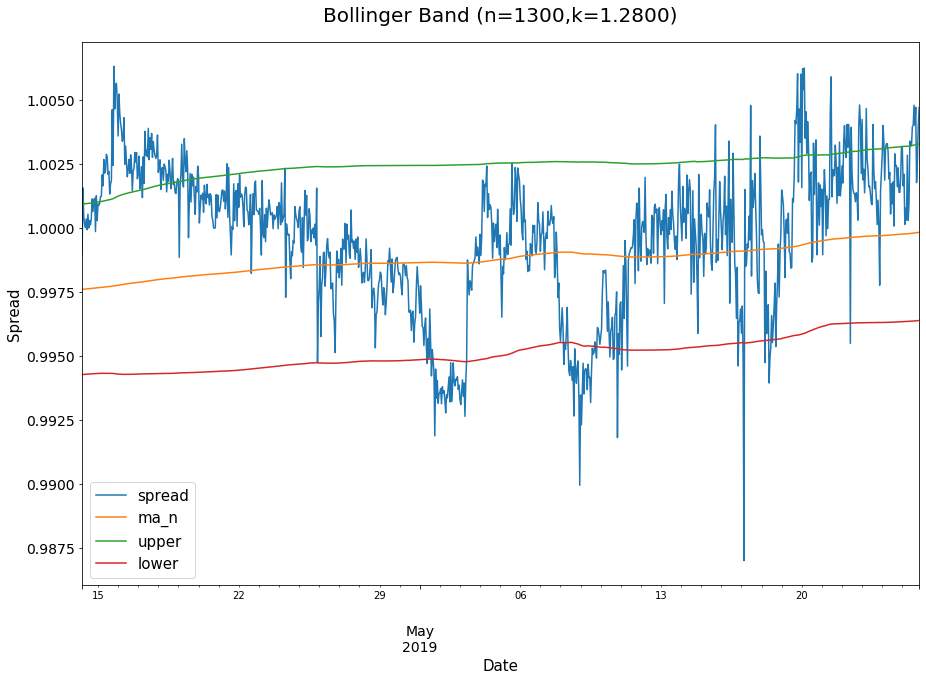

In [6]:
bollinger_graph(result, n=n, k=k, sample_start=12000, sample_end=13000)

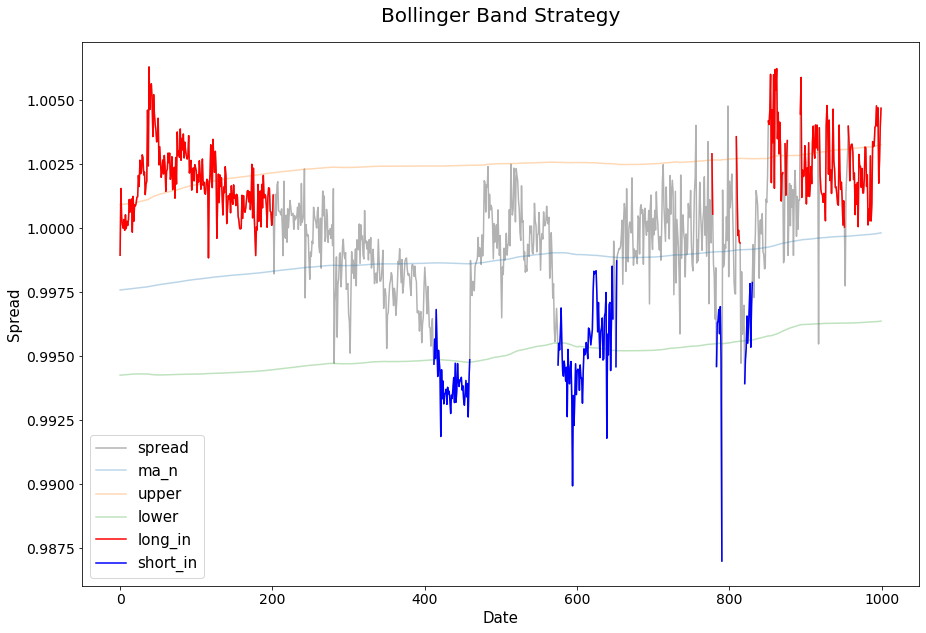

In [7]:
## 빨간선은 Long_in(Long Near, Short Far), 파란선은 Short_in(Short Fear, Long Far) position에 있는 상태
strategy_graph(result, sample_start = 12000, sample_end = 13000)

# #Backtest Period 중 Trade별 P&L과 Holding Period 분석

# - Long Trade 횟수가 약 100회, Short Trade 횟수가 약 80회로 Long Trade 횟수가 더 많다. P&L과 Holding Period 측면에서는 Long Trade와 Short Trade 간에 유의미한 차이는 보이지 않는다

# - Long trade와 Short Trade의 P&L이 대부분 양수이고 [0,0.01] 사이에 대부분 분포하고 있다. 작지만 꾸준한 profit 을 얻으며, Large Gain도 없지만 Large Loss에도 거의 노출되지 않는다. 확실한 수익을 얻을 수 있다고 판단할 때만 진입한다. 
 

# - Holding Period는 0부터 최대 약 600시간까지 다양하게 분포하고 있다.

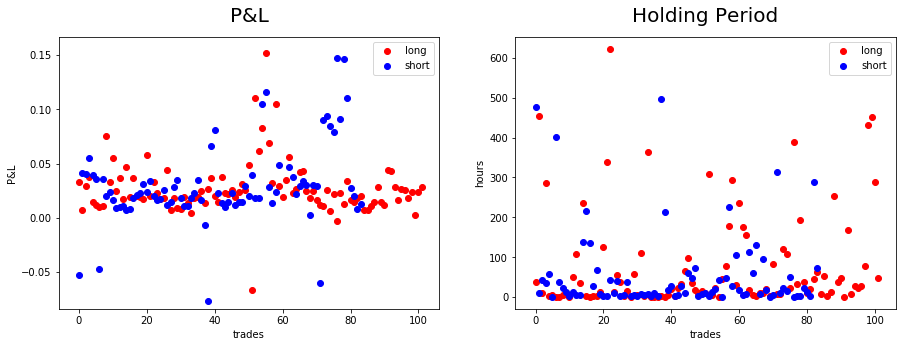

In [8]:
## Long trade(Long Near, Short Far)와 Short trade(Short Fear, Long Far)별 P&L과 Holding Period
trade_graph(trades)

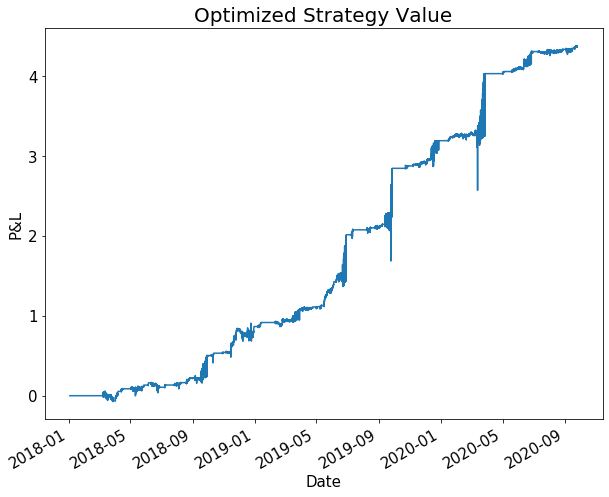

In [9]:
result['bal_t'].plot(figsize=(10,8))
plt.title('Optimized Strategy Value', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('P&L', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()

# Parameter Optimization

# N : 이동평균 기간
# K : Upper, Lower Limit을 만들 때 쓰이는 계수 
### - 이동평균으로부터의 오차가 정규분포를 따른다고 가정하면, 표준정규분포의 Z_alpha 값을 K로 사용했을 때 Entry timing이 전체 기간 중 (1-alpha)만큼 발생할 것으로 가정하는 것이다. 
# Rollover : 근월물 만기가 오기 얼마 전에 rollover를 할 것인가

In [10]:
## Grid 설정
n_grid = [100, 500, 900, 1300]
k_grid = [norm.ppf(0.7).round(2), norm.ppf(0.8).round(2), norm.ppf(0.9).round(2)]
rollover_grid = [24*i for i in [1,2,3]]

grids = []
for n in n_grid:
    for k in k_grid:
        for rollover in rollover_grid:
            grids.append((n, k, rollover))

print('Total Grid Number : {0}'.format(len(grids)))

Total Grid Number : 36


In [11]:
## Grid 별로 탐색 후 결과 저장
metrics = []
total_time = 0
balance = pd.DataFrame()
for i,grid in enumerate(grids):
    start = time()
    ## Parameter
    n, k, rollover = grid 
    port = bollinger_str(n,k, data)
    port['rollover_out'] = rollover_out(data, period=rollover)
    
    ## Leverage = 1로 일정하게 설정
    port['leverage'] = np.ones(len(port))
        
    ## Backtest 결과 도출
    ret, std, sharpe_ratio, result = backtest(data,port, commission=0.00075)
    balance[grid] = result['bal_t']
    metrics.append([ret, std, sharpe_ratio]) ## 결과 저장
    
    ## 실행시간 측정
    running_time = time()-start
    total_time += running_time
    exp_time = (len(grids) - i - 1) * running_time / 60
    print('{0}번째 Iteration에 소요된 시간 : {1:.4f}초, 총 소요시간 : {2:.4f}초, 예상 소요시간 : {3:.4f}분'
          .format(i+1, running_time, total_time, exp_time))
    
## Backtest 결과 저장
grid_df = pd.DataFrame(grids, columns = ['n', 'k', 'rollover'])
metric_df = pd.DataFrame(metrics, columns=['ret','std','sharpe_ratio'])
compare = pd.concat([grid_df, metric_df], axis=1)

1번째 Iteration에 소요된 시간 : 6.0425초, 총 소요시간 : 6.0425초, 예상 소요시간 : 3.5248분
2번째 Iteration에 소요된 시간 : 4.8268초, 총 소요시간 : 10.8693초, 예상 소요시간 : 2.7352분
3번째 Iteration에 소요된 시간 : 4.7014초, 총 소요시간 : 15.5707초, 예상 소요시간 : 2.5858분
4번째 Iteration에 소요된 시간 : 4.8760초, 총 소요시간 : 20.4467초, 예상 소요시간 : 2.6005분
5번째 Iteration에 소요된 시간 : 4.9277초, 총 소요시간 : 25.3745초, 예상 소요시간 : 2.5460분
6번째 Iteration에 소요된 시간 : 3.5097초, 총 소요시간 : 28.8842초, 예상 소요시간 : 1.7549분
7번째 Iteration에 소요된 시간 : 3.9226초, 총 소요시간 : 32.8068초, 예상 소요시간 : 1.8959분
8번째 Iteration에 소요된 시간 : 3.7390초, 총 소요시간 : 36.5458초, 예상 소요시간 : 1.7449분
9번째 Iteration에 소요된 시간 : 2.9335초, 총 소요시간 : 39.4793초, 예상 소요시간 : 1.3201분
10번째 Iteration에 소요된 시간 : 2.9222초, 총 소요시간 : 42.4014초, 예상 소요시간 : 1.2663분
11번째 Iteration에 소요된 시간 : 2.8235초, 총 소요시간 : 45.2249초, 예상 소요시간 : 1.1764분
12번째 Iteration에 소요된 시간 : 3.1994초, 총 소요시간 : 48.4243초, 예상 소요시간 : 1.2798분
13번째 Iteration에 소요된 시간 : 3.1277초, 총 소요시간 : 51.5520초, 예상 소요시간 : 1.1989분
14번째 Iteration에 소요된 시간 : 3.1147초, 총 소요시간 : 54.6667초, 예상 소요시간 : 1.1420분
15번째 Iteration에 

In [12]:
## Return, Standard Deviation, Sharpe Ratio의 최대, 최소 보기
metric_summary(compare)

# of grid : 36
Max Return : 0.7552, Parameter : N=100.0, K=1.28, Rollover=48.0
Min Return : -0.3031, Parameter : N=100.0, K=0.52, Rollover=72.0


Max Sharpe Ratio : 5.4080, Parameter : N=100.0, K=0.84, Rollover=24.0
Min Sharpe Ratio : -2.0861, Parameter : N=100.0, K=0.52, Rollover=72.0


Min Standard Deviation : 0.0405, Parameter : N=100.0, K=0.84, Rollover=24.0
Max Standard Deviation : 0.1671, Parameter : N=100.0, K=1.28, Rollover=24.0


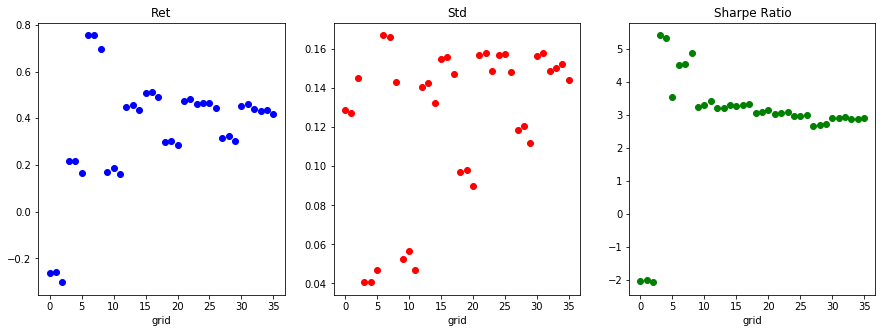

In [13]:
## Grid 별 Ret, Std, Sharpe Ratio의 분포
metric_graph(compare)

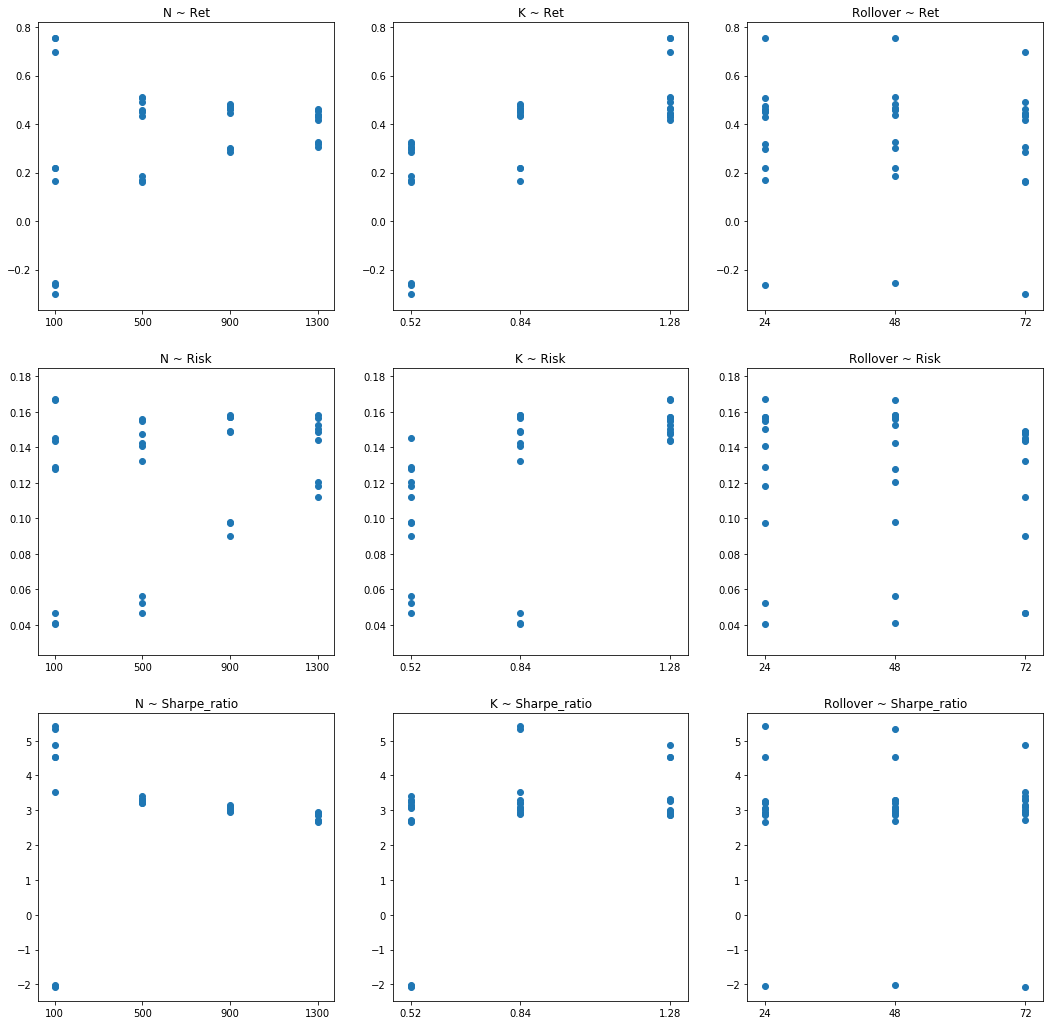

In [14]:
## Parameter 변화에 따른 Metric들의 Sensitivity
sensitive_graph(compare, n_grid, k_grid, rollover_grid)

# Grid Search Result 

## 1. n, k가 증가할수록 Parameter 변화에 따른 Return, Sharpe Ratio의 분산이 작아진다.
###  - n이 증가하면 upper, lower limit이 평행선에 가까워지고, k가 커지면 upper, lower limit이 멀어진다. 따라서 n과 k가 증가할수록 Entry timing이 줄어들어서 Trade 횟수를 줄이면서 확실한 수익기회라고 판단할 때만 진입하는 전략이 된다.
### - n과 k가 작을 때 Return과 Sharpe Ratio가 매우 높은 경우가 있는데, 이는 Overfitting의 결과일 수 있다. n과 k가 작을수록 parameter 변화에 따라 metric 변동이 심하므로, 시장 상황이 바뀌었을 때 동일한 수익을 준다는 보장이 없다. 

## 2. k가 증가할수록 Return, Sharpe Ratio가 증가하는 경향이 있다.

## 3. Standard Deviation은 Parameter 변화에 따른 특별한 경향은 보이지 않는다.

## 4. Rollover 기간은 큰 영향을 주지 못하는 것으로 보인다.

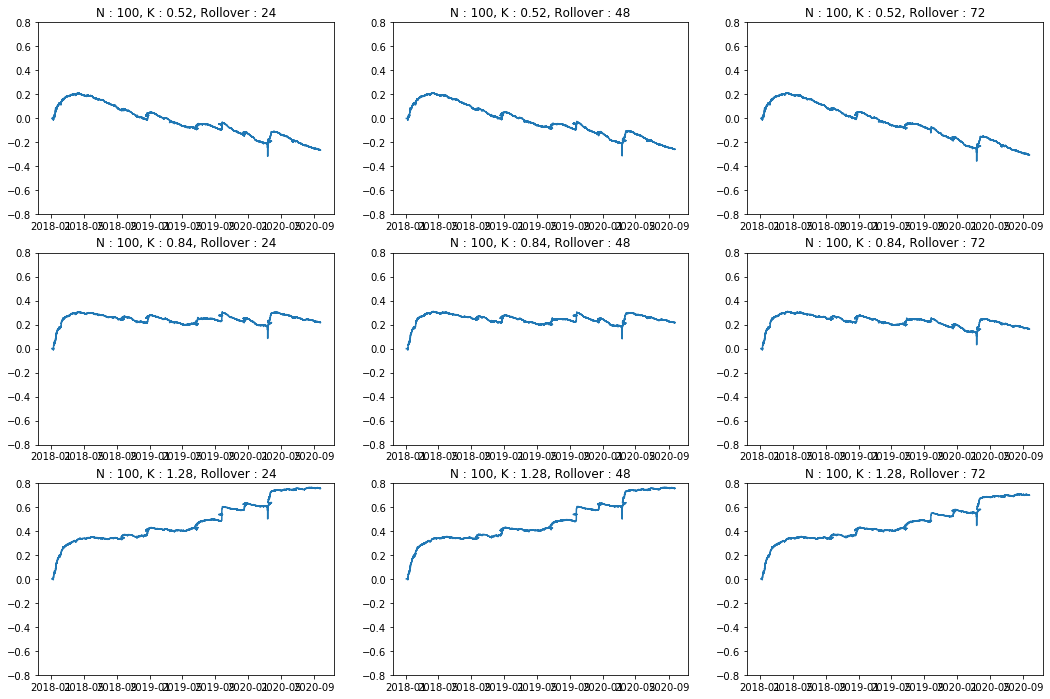

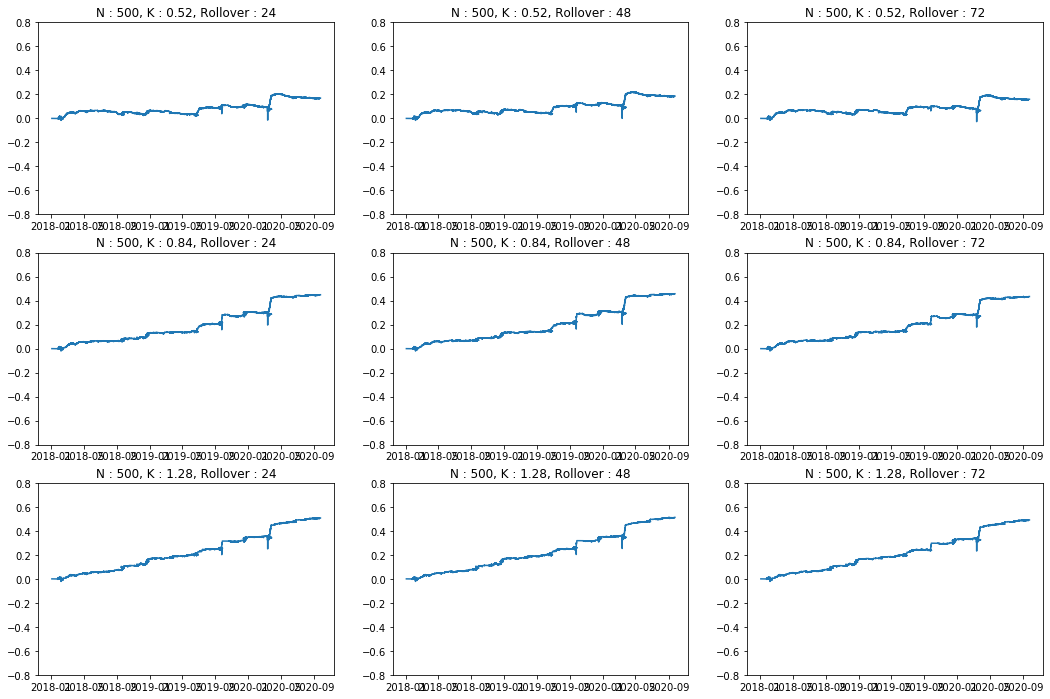

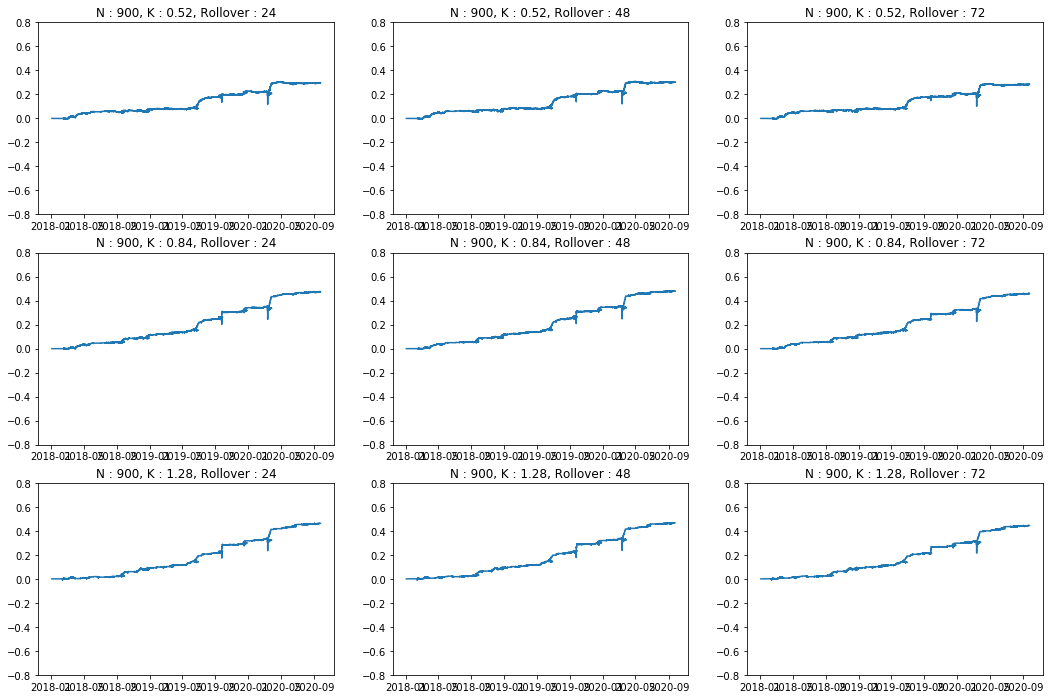

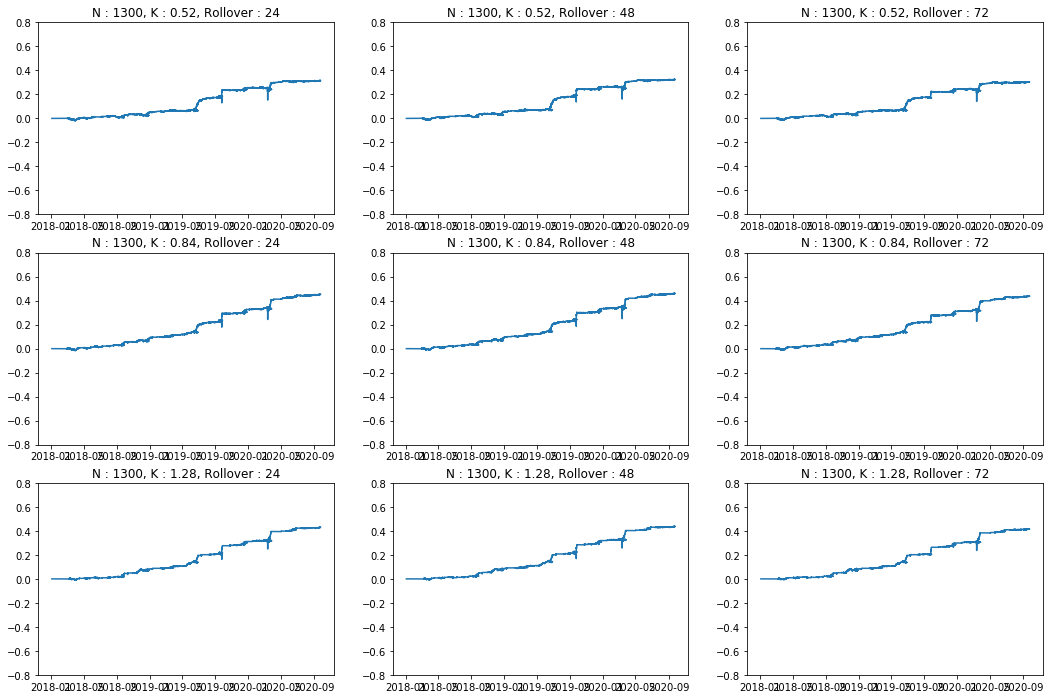

In [15]:
## Grid별 Return Time Series
for i in range(4):
    plt.figure(figsize=(3*6, 3*4))
    for j in range(1,9+1):        
        plt.subplot(3, 3, j)
        plt.title('N : {0}, K : {1}, Rollover : {2}'.format(grids[i*9+j-1][0], grids[i*9+j-1][1], grids[i*9+j-1][2]))
        plt.ylim(-0.8, 0.8)
        plt.plot(balance.iloc[:,i*9+j-1])
    plt.show()

In [18]:
compare[(compare['n']==1300)]

,n,k,rollover,ret,std,sharpe_ratio
27,1300,0.52,24,0.315805,0.118430,2.666597
28,1300,0.52,48,0.324864,0.120413,2.697916
29,1300,0.52,72,0.304822,0.111820,2.726009
30,1300,0.84,24,0.452735,0.156312,2.896362
31,1300,0.84,48,0.460629,0.158019,2.915029
32,1300,0.84,72,0.437717,0.148680,2.944027
33,1300,1.28,24,0.429780,0.150456,2.856524
34,1300,1.28,48,0.437489,0.152539,2.868039
35,1300,1.28,72,0.416411,0.143991,2.891923


In [19]:
compare[(compare['n']==1300) & (compare['k']==1.28)]

,n,k,rollover,ret,std,sharpe_ratio
33,1300,1.28,24,0.429780,0.150456,2.856524
34,1300,1.28,48,0.437489,0.152539,2.868039
35,1300,1.28,72,0.416411,0.143991,2.891923


In [17]:
compare[(compare['n']==1300) & (compare['k']==1.28) & (compare['rollover']==48)]

,n,k,rollover,ret,std,sharpe_ratio
34,1300,1.28,48,0.437489,0.152539,2.868039


## Parameter 설정 : 
## n : n이 클수록 Parameter 변화에 따른 Return, Sharpe Ratio의 분산이 작아지므로, 가장 큰 1300 선택
## k : k는 클수록 Return은 높아지고, parameter 변화에 따른 Return과 Sharpe Ratio의 분산도 작아지므로 가장 큰 1.28을 선택
## Rollover : Return을 극대화할 수 있는 48로 설정

# #Performance
## 1. 큰 손실없이 꾸준히 증가하며, 큰 손실구간이 없으므로 레버리지를 크게 가져갈 수 있다.
## 2. Parameter를 변경해도 그래프의 형태가 유사하기 때문에 강건한 모형이라고 볼 수 있다.
## 3. N, K를 높일수록 진입과 청산의 숫자가 감소한다. 즉, 수익이 좀 더 확실하게 느껴질 때에만 포지션에 진입한다. 따라서 Losing Trade 숫자를 줄임으로써 수익을 얻는다.

# #Limitation
## 1. Leverage : 꾸준히 증가하는 형태의 그래프에서 최적의 레버리지를 어떻게 설정할지 결정하지 못했다. spread의 n기간 분산에 반비례하는 레버리지를 설정해보았다. 그런데 수익 측면이나 변동성 측면 모두 결과가 더 나빠졌다. 그래서 레버리지를 일단 고정하였다. 

## 이에 대한 대안으로 투자자에 위험회피 성향에 따른 Leverage를 설정할 수 있을 것이다. 투자자가 Trade 별로 감당할 수 있는 Largest Loss를 정하고, Leverage를 1로 설정했을 때 Backtest에서 나온 Largest Loss의 비율을 레버리지로 설정한다. 

$$ Leverage = \frac{Acceptable \, Largest \, Loss}{Largest \, Loss \, when \, Leverage \, 1} $$

## 예를 들어 Backtest 결과 Trade 당 최대 손실이 -0.5%일 때, Trade 한 번당 5%의 손실을 감당할 수 있는 투자자는 10배의 레버리지를 사용한다.

## 2. 체결 실패 : 근월물과 원월물 포지션에 진입할 때 한 쪽 주문이 일부만 체결된 때 어떻게 해야할 것인지 고민. 일부만 체결된 포지션에 맞춰서 수량을 조절하거나, 두 주문 다 취소하는 방법이 있다. 어떤 전략이 유용한지 테스트해보지 못함. 

## 일부만 체결된 포지션에 맞춰서 수량을 조절해야 하는 경우는 Trade가 많지 않아서 한 번의 기회를 놓치는 것이 수익에 큰 영향을 줄 수 있는 경우이다.
## 주문을 취소하지 않을 때의 단점은 수량 조절 과정에서 bis-ask spread만큼의 비용이 바로 발생한다는 점이 있다, 전략적인 레버리지 비율이 변경될 수 있다는 점이 있다.

## 주문을 놓치는 케이스가 얼마나 발생할지에 대한 데이터가 있어야 수치적으로 검증할 수 있을 것으로 보인다. 직관적으로 생각해보기에는 최적화된 전략이 Trade 횟수가 많지 않으므로 일부 체결만 되더라도 포지션에 진입해야 할 것으로 보인다.

## 포지션에 점진적으로 진입하는 방법으로 이를 해결할 수 있으나, 충분한 스프레드를 얻지 못하게 되고, Rebalancing이 잦아지면 수수료 비용이 커질 수 있다는 문제점이 있다. 그래서 점진적으로 진입하는 방식은 고려대상에서 제외 하였다.